This notebook shows how to apply Neural Networks to predict the global temperature, based on the time series of CO2 & CH4.

By Weiwei Zhan

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

These directories will be used to store the ClimateBench dataset

In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

make_dir(train_path)
make_dir(test_path)

## Download & unzip the ClimateBench Dataset

Now let's download the ClimateBench dataset using `wget` 


First download for the training & validation sets (this may takes about 3min)


**Note:** Once you have successfully run the following 4 cells, you don't need to re-do it since the data have already been downloaded & unzipped.  

In [3]:
!wget https://zenodo.org/record/7064308/files/train_val.tar.gz

--2022-09-28 11:56:10--  https://zenodo.org/record/7064308/files/train_val.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839129430 (800M) [application/octet-stream]
Saving to: ‘train_val.tar.gz’

train_val.tar.gz    100%[===================>] 800.26M  5.03MB/s    in 5m 41s  

2022-09-28 12:01:53 (2.34 MB/s) - ‘train_val.tar.gz’ saved [839129430/839129430]



Then download for the test set

In [4]:
!wget https://zenodo.org/record/7064308/files/test.tar.gz

--2022-09-28 12:01:53--  https://zenodo.org/record/7064308/files/test.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74442376 (71M) [application/octet-stream]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>]  70.99M  1.91MB/s    in 59s     

2022-09-28 12:02:53 (1.21 MB/s) - ‘test.tar.gz’ saved [74442376/74442376]



Unzip the downloaded datasets, and put them into the previously defined directories

In [5]:
!tar -C $test_path -xzf test.tar.gz 

In [6]:
!tar -C $train_path -xzf train_val.tar.gz

## Some visualization of the ClimateBench data

Before we use ClimateBench data to train ML models, let's have a quick look about the data.

### historical simulations


ClimateBench provides historical simulations - it can simulate how emissions of greenhouse gases (e.g., CO2, CH4) & surface air temperature (tas) vary over the historical time period starting from 1850.


There are 3 historical scenarios used here:

In [3]:
inputs = glob(os.path.join(train_path , "inputs_his*.nc"))
inputs.sort()

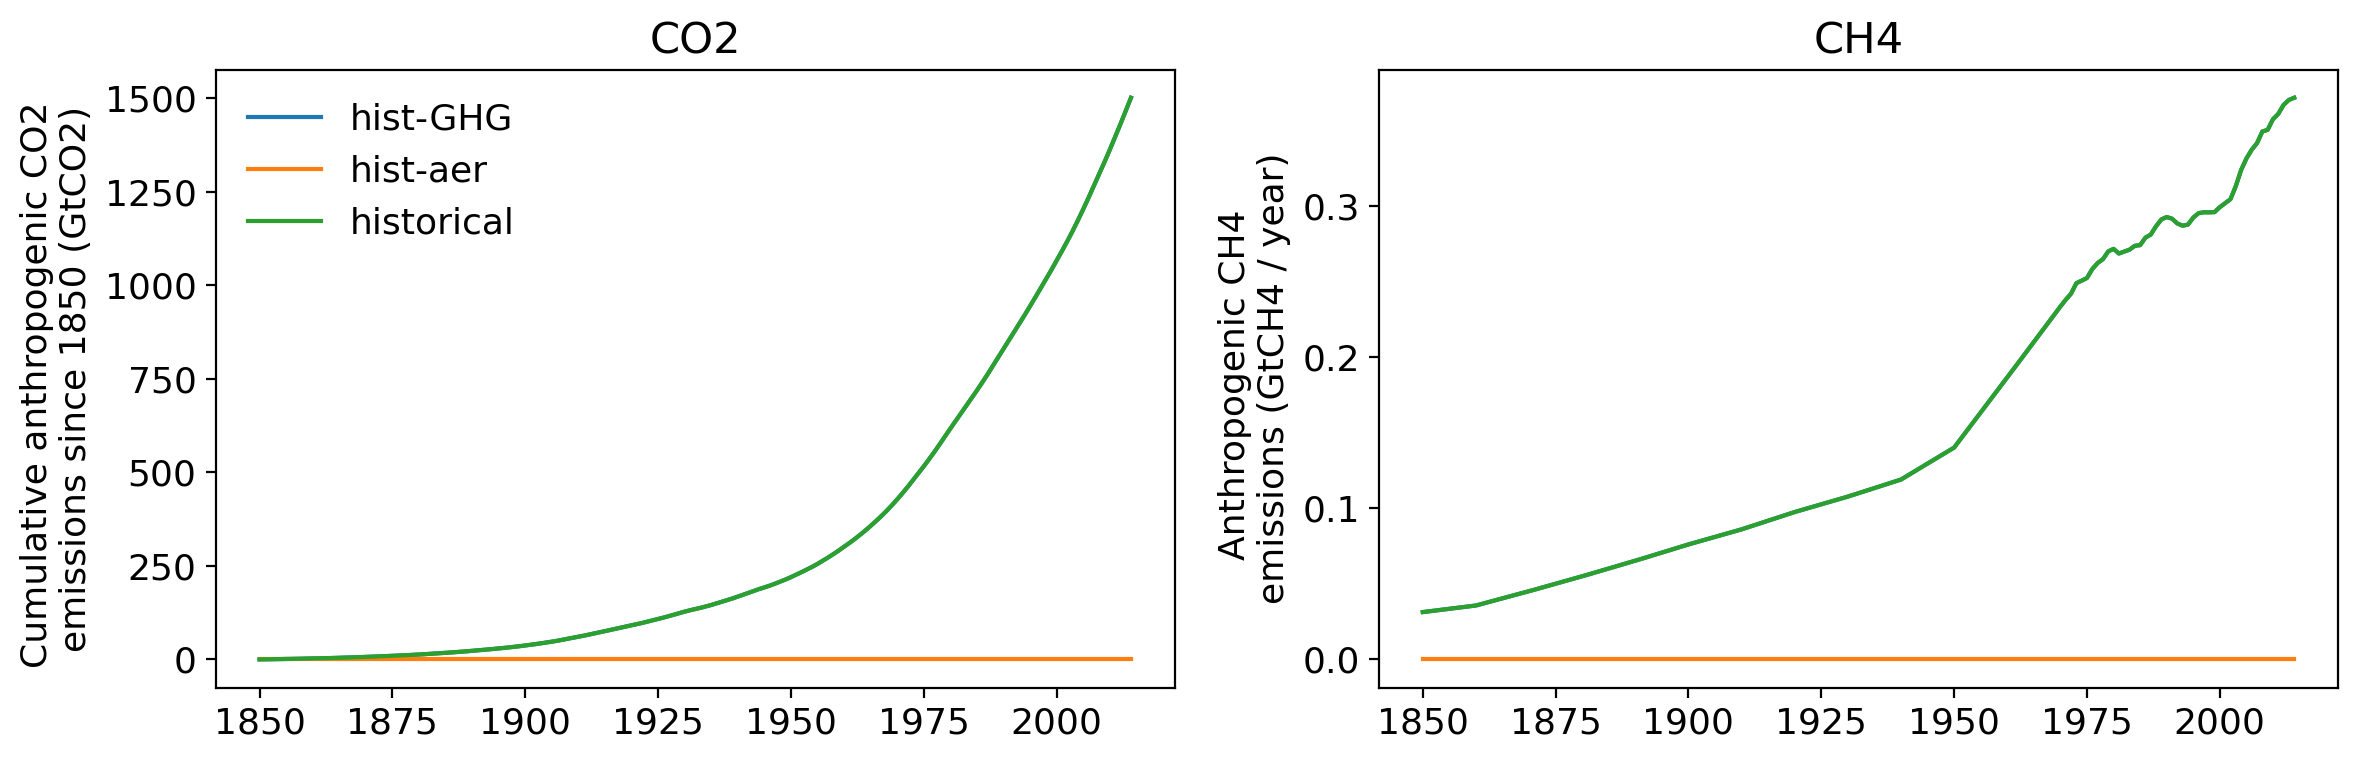

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
SECONDS_IN_YEAR = 60*60*24*365 #s
for input in inputs:

    label=input.split('_')[-1][:-3]
    X = xr.open_dataset(input)
    x = range(1850, 2015)
    
    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0].plot(x, X['CO2'].data, label=label)
    axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[1].plot(x, X['CH4'].data, label=label)
    axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    
axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()




Note that `hist-GHG` has the exact same CO2 & CH4 changes as `historical`

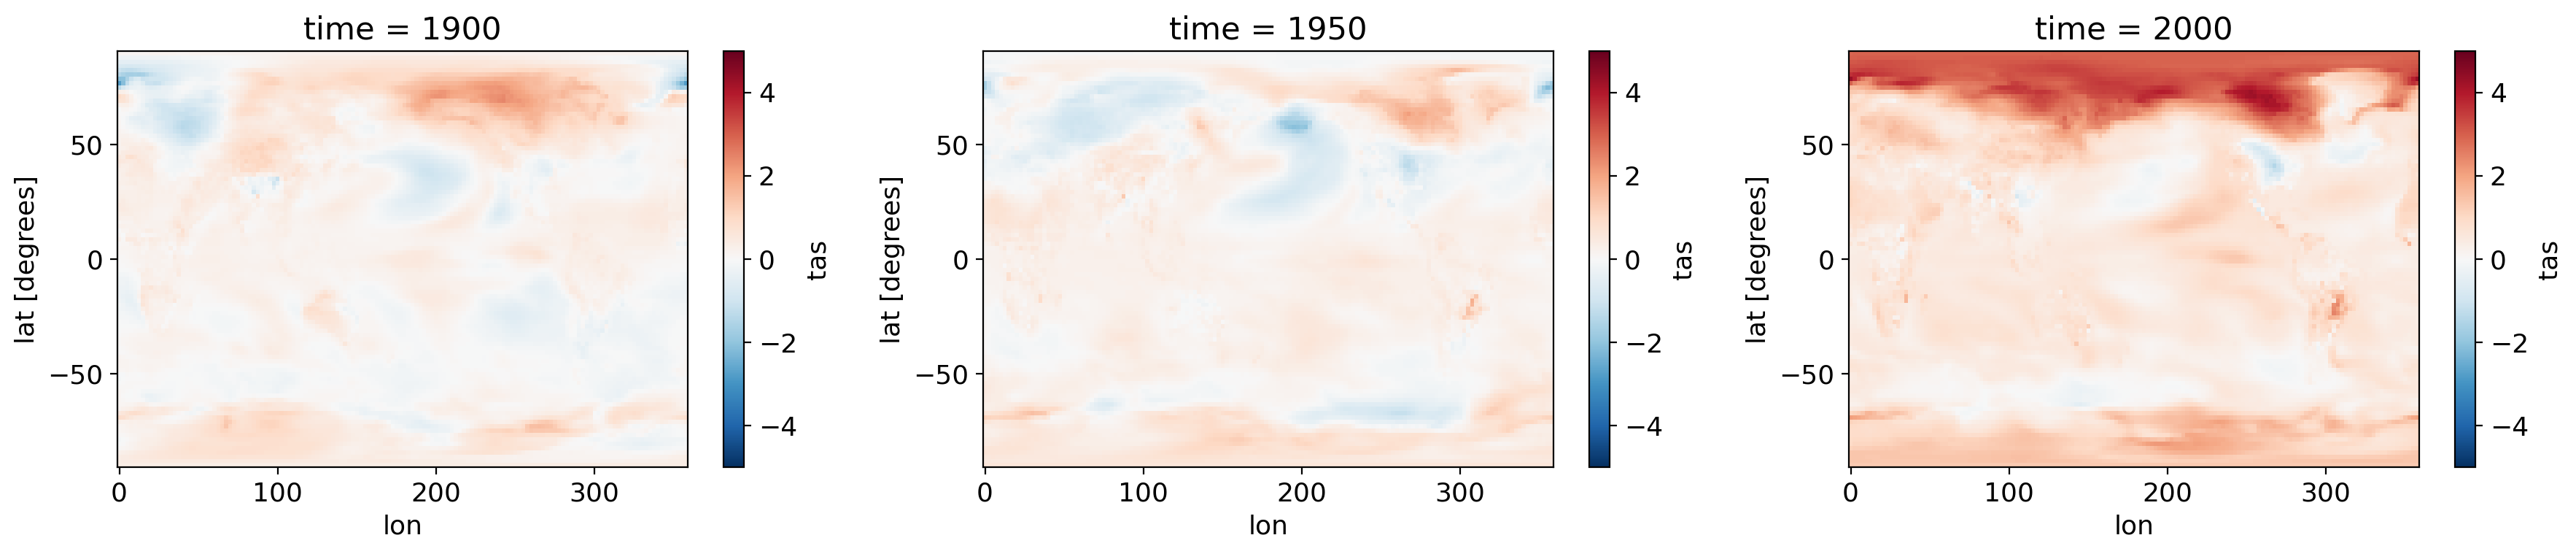

In [5]:
y = xr.open_dataset(os.path.join(train_path , "outputs_historical.nc")).mean(dim="member")[['tas']].drop(['quantile'])


fig,axes = plt.subplots(figsize=(18,4),ncols=3)
yr0, yr1, yr2 = 1900, 1950, 2000
vmin, vmax = -5, 5

y.sel(time=yr0).tas.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr1).tas.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr2).tas.plot(ax=axes[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

plt.tight_layout()

### future scenarios

Also, ClimateBench can project future changes under different scenarios (e.g., ssp126, ssp245, ssp585).


There are 5 future scenarios provided here:

In [6]:
inputs = glob(os.path.join(train_path, "inputs_s*.nc"))
inputs.sort()
inputs += glob(os.path.join(test_path, "inputs_s*.nc"))

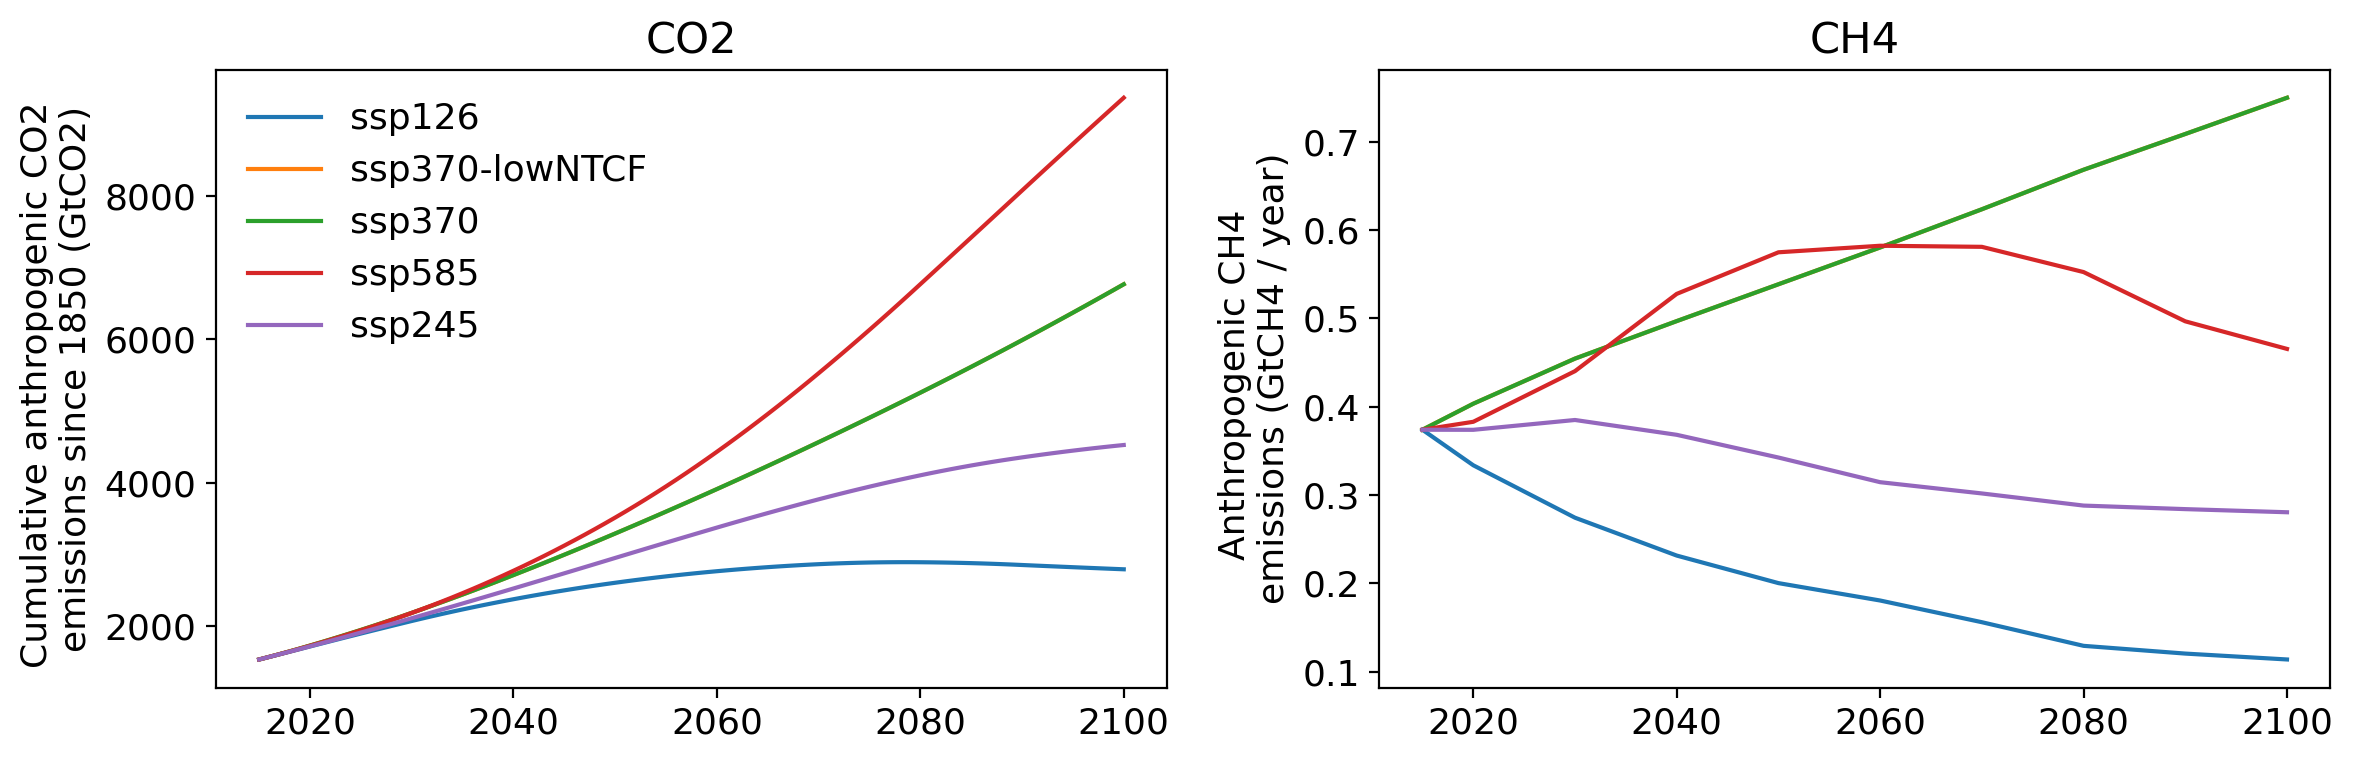

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
SECONDS_IN_YEAR = 60*60*24*365 #s
for input in inputs:

    label=input.split('_')[-1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)
    
    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0].plot(x, X['CO2'].data, label=label)
    axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[1].plot(x, X['CH4'].data, label=label)
    axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    
axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()



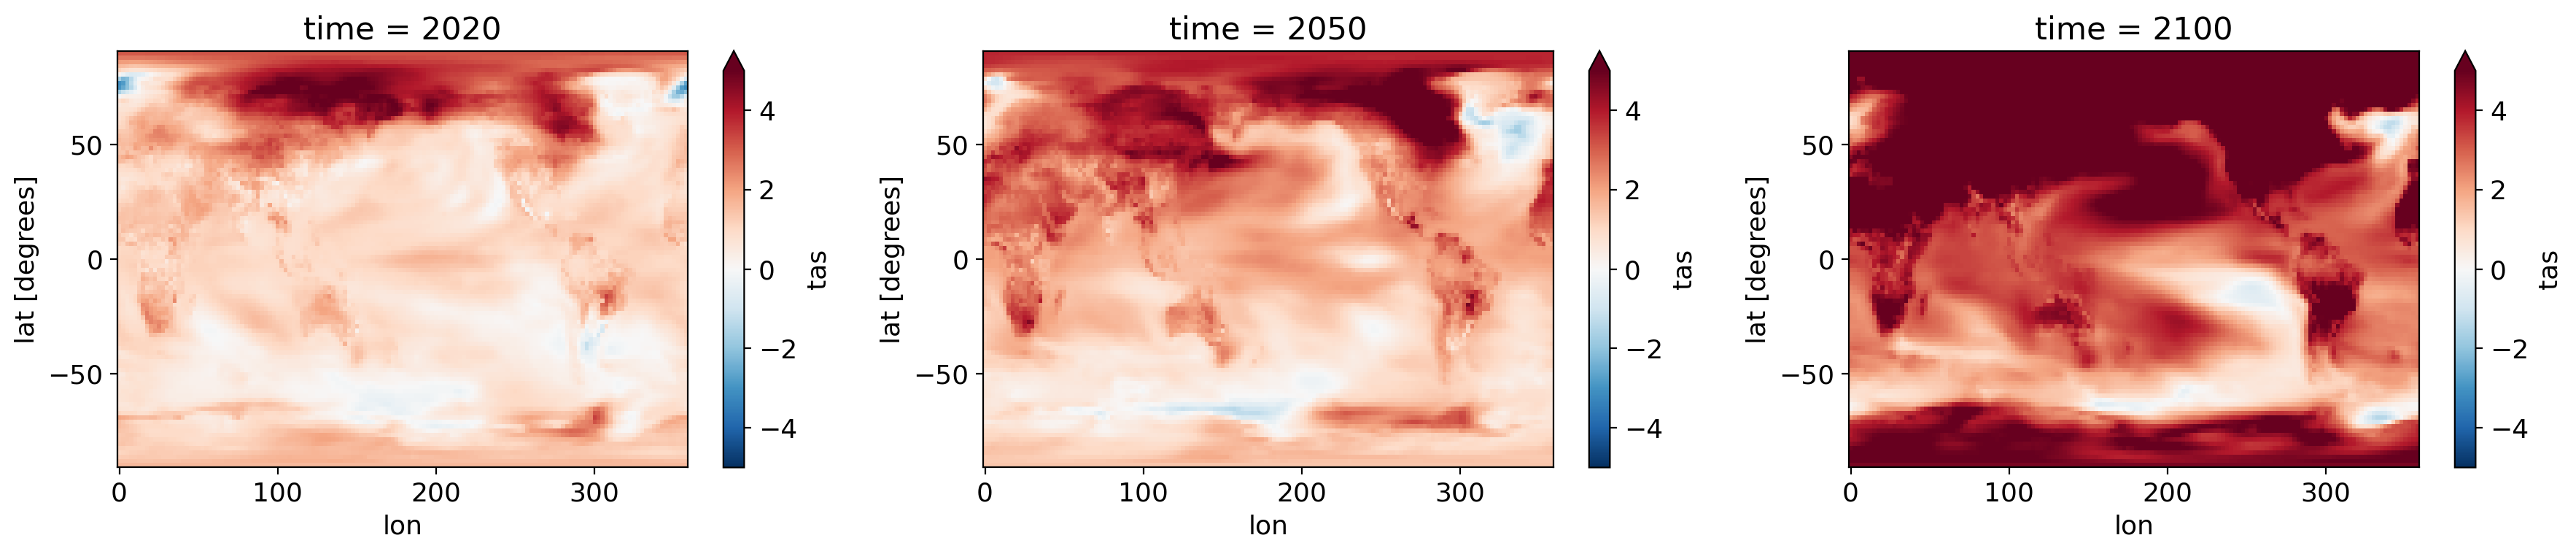

In [8]:
y = xr.open_dataset(os.path.join(train_path,'outputs_ssp585.nc')).mean(dim="member")[['tas']].drop(['quantile'])

fig,axes = plt.subplots(figsize=(18,4),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y.sel(time=yr0).tas.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr1).tas.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr2).tas.plot(ax=axes[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

plt.tight_layout()

## Use Neural Networks (NN) for temperature prediction


Now, we are trying to use NN to predict the surface air temperature (tas), based on the time series of CO2 & CH4 emissions

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train NN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [9]:
# Training set
train_files    = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [10]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

This is how our predictors & predictand data look like:

In [11]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


Note that here we stack the original 2-D tas data into a single dimension (for the purpose of NN implementation)

In [12]:
y_train_df.head()

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

#### Data normalization

Let's normalize the input predictors by there mean & std

In [13]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(753, 2) (753, 13824)


### 2. Define the NN structure

Now the data preprocessing has been finished! Let's define our NN structure, which is shown in the below schematic.

Here the NN we use has 3 hidden layers, and each hidden layer has 64 neurons. 

The NN input layer has 2 neurons, corresponding to CO2 & CH4 inputs respectively. 

The NN outputs are the global tas, each neuron of the output layer corresponds to each pixel. There are 13824 pixels in total (number of latitude: 96, number of longitude: 144)

![title](https://drive.google.com/uc?export=view&id=1wCIEX6GAN5h0_XOd23eUtdnkjpOJPpde)

Here are the hyperparameters for the NN training, such as the number of neurons per layer, learning rate, etc. Note that these hyperparameters here are for demonstration purposes only - they are not optimized.  

In [14]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [15]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2022-10-19 06:31:19.337157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 13824)             898560    
                                                                 
Total params: 907,072
Trainable params: 907,072
Non-trainable params: 0
_________________________________________________________________


### 3. Train & save the NN model

Here we use `EarlyStopping` to avoid over-fitting

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
10/10 [==============================] - 0s 18ms/step - loss: 3.6789 - val_loss: 0.5562
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 3.4118 - val_loss: 0.5022
Epoch 3/50
10/10 [==============================] - 0s 9ms/step - loss: 2.7222 - val_loss: 0.3964
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - loss: 1.5573 - val_loss: 0.2747
Epoch 5/50
10/10 [==============================] - 0s 9ms/step - loss: 0.8716 - val_loss: 0.2489
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.5109 - val_loss: 0.3046
Epoch 7/50
10/10 [==============================] - 0s 9ms/step - loss: 0.4384 - val_loss: 0.2984
Epoch 8/50
10/10 [==============================] - 0s 9ms/step - loss: 0.4100 - val_loss: 0.3141
Epoch 9/50
10/10 [==============================] - 0s 9ms/step - loss: 0.3949 - val_loss: 0.3055
Epoch 10/50
10/10 [==============================] - 0s 9ms/step - loss: 0.3900 - val_loss: 0.2958
Epoch 11/50
10/10

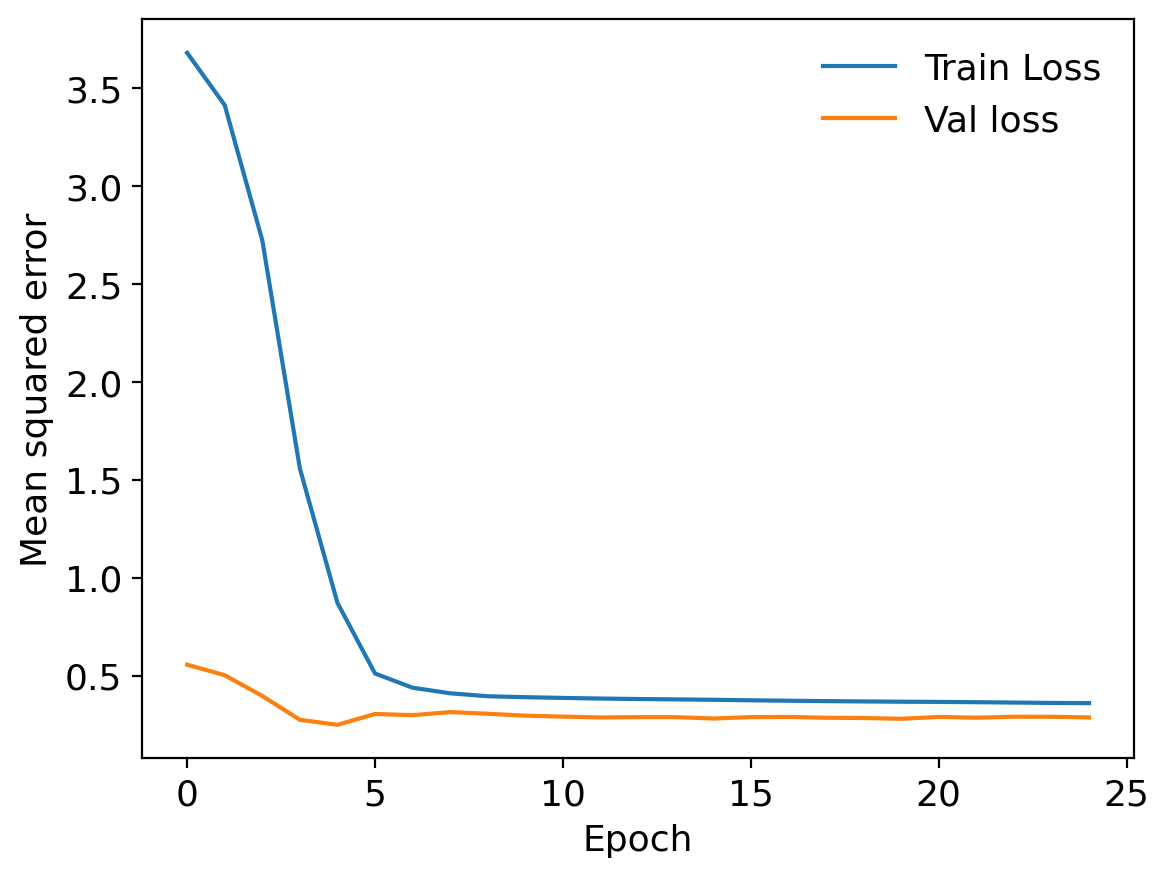

In [18]:
plot_history(history)

we can save the trained model as the `.h5` file.

In [19]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [20]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

### 4. Evaluate the trained model

Now let's evaluate the trained NN on the test set, by comparing the NN predictions against the tas originally simulated under the ssp245 scenario. 

In [21]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

In [22]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 [==============================] - 0s 2ms/step


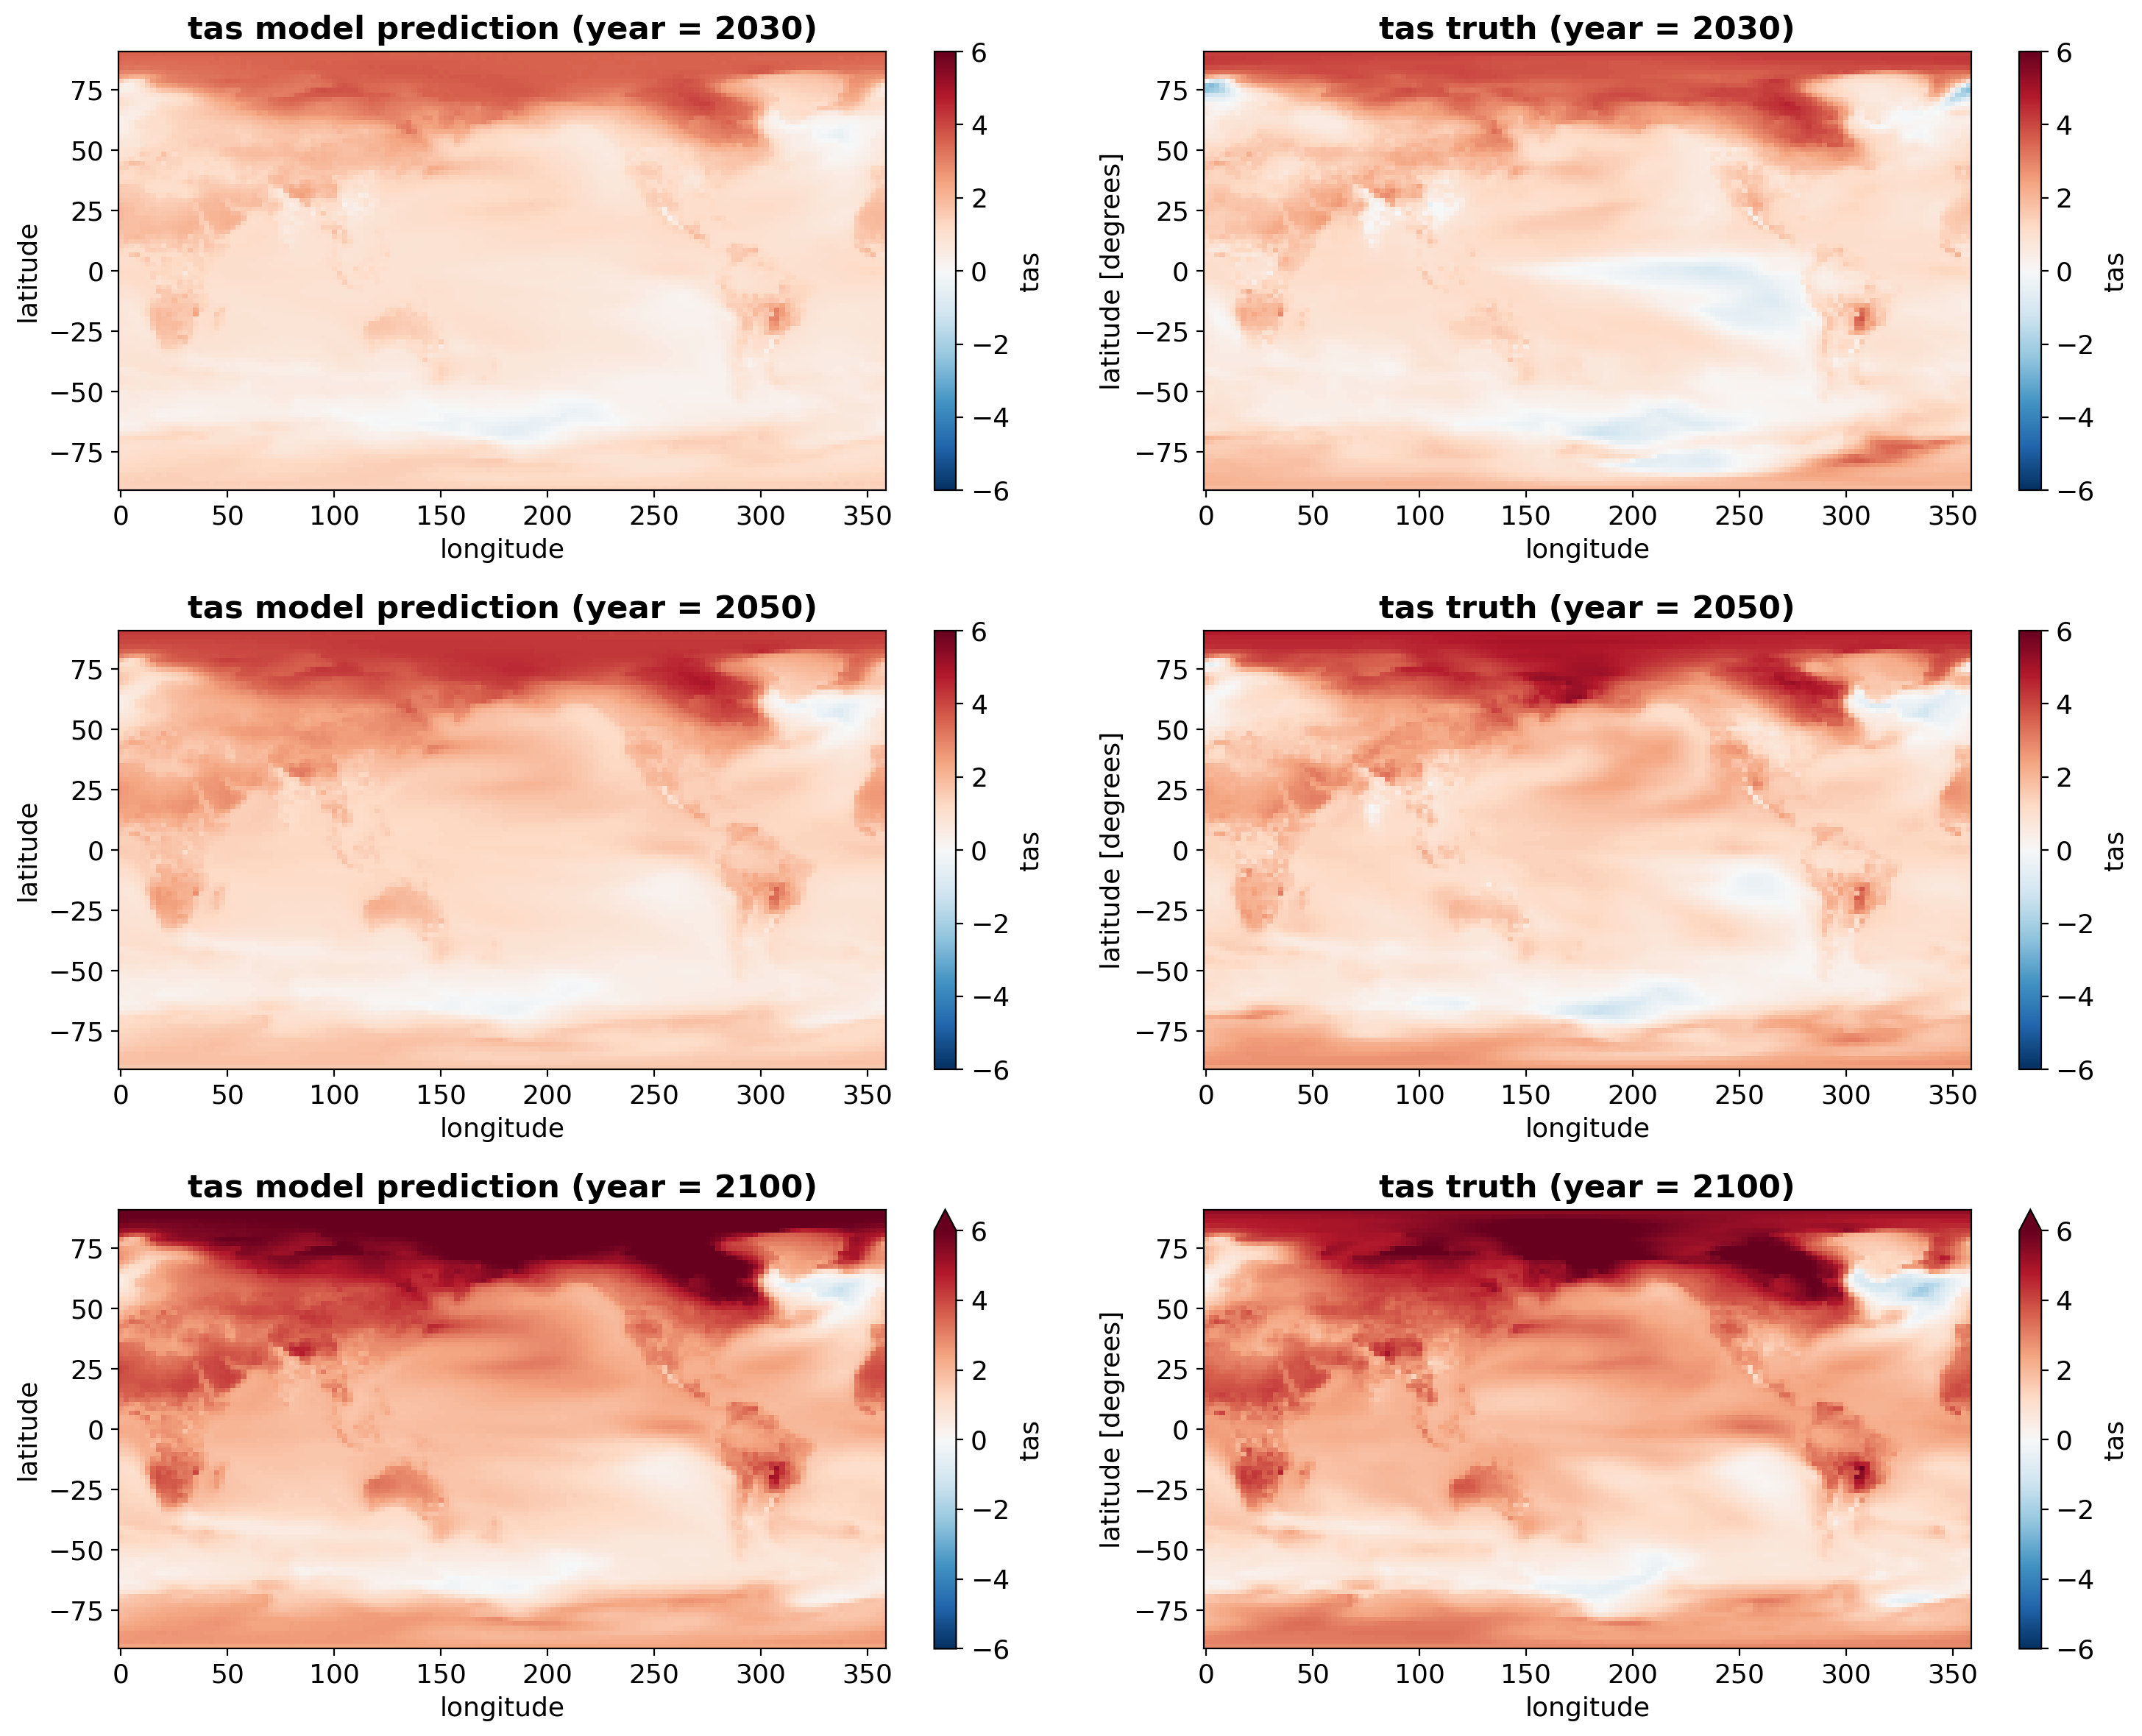

In [23]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()